In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, balanced_accuracy_score,classification_report,\
                            plot_confusion_matrix, confusion_matrix
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.model_selection import train_test_split

import lightgbm as lgb
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import RandomNormal
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

np.random.seed(1635848)

In [39]:
import warnings
warnings.filterwarnings('ignore')

In [40]:
class cGAN():
    
    """
    Class containing 3 methods (and __init__): generator, discriminator and train.
    Generator is trained using random noise and label as inputs. Discriminator is trained
    using real/fake samples and labels as inputs.
    """
    
    def __init__(self,latent_dim=32, out_shape=14):
        
        self.latent_dim = latent_dim
        self.out_shape = out_shape 
        self.num_classes = 2
        # using Adam as our optimizer
        optimizer = Adam(0.0002, 0.5)
        
        # building the discriminator
        self.discriminator = self.discriminator()
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # building the generator
        self.generator = self.generator()

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])
        
        # we don't train discriminator when training generator
        self.discriminator.trainable = False
        valid = self.discriminator([gen_samples, label])

        # combining both models
        self.combined = Model([noise, label], valid)
        self.combined.compile(loss=['binary_crossentropy'],
                              optimizer=optimizer,
                             metrics=['accuracy'])


    def generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.latent_dim)(label))
        
        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)

        return Model([noise, label], gen_sample, name="Generator")

    
    def discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(512, input_dim=self.out_shape, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        
        model.add(Dense(256, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(128, kernel_initializer=init))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))
        
        model.add(Dense(1, activation='sigmoid'))
        
        gen_sample = Input(shape=(self.out_shape,))
        label = Input(shape=(1,), dtype='int32')
        label_embedding = Flatten()(Embedding(self.num_classes, self.out_shape)(label))

        model_input = multiply([gen_sample, label_embedding])
        validity = model(model_input)

        return Model(inputs=[gen_sample, label], outputs=validity, name="Discriminator")


    def train(self, X_train, y_train, pos_index, neg_index, epochs, sampling=False, batch_size=32, sample_interval=100, plot=True): 
        
        # though not recommended, defining losses as global helps as in analysing our cgan out of the class
        global G_losses
        global D_losses
        
        G_losses = []
        D_losses = []
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
            
            # if sampling==True --> train discriminator with 8 sample from postivite class and rest with negative class
            if sampling:
                idx1 = np.random.choice(pos_index, 8)
                idx0 = np.random.choice(neg_index, batch_size-8)
                idx = np.concatenate((idx1, idx0))
            # if sampling!=True --> train discriminator using random instances in batches of 32
            else:
                idx = np.random.choice(len(y_train), batch_size)
            samples, labels = X_train[idx], y_train[idx]
            samples, labels = shuffle(samples, labels)
            
            # Sample noise as generator input
            noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth = (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid 
                fake_smooth = fake
                
            # Train the discriminator
            self.discriminator.trainable = True
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator
            self.discriminator.trainable = False
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)
            # Train the generator
            g_loss = self.combined.train_on_batch([noise, sampled_labels], valid)

            if (epoch+1)%sample_interval==0:
                print('[%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, epochs, d_loss[0], g_loss[0]))
            G_losses.append(g_loss[0])
            D_losses.append(d_loss[0])
            if plot:
                if epoch+1==epochs:
                    plt.figure(figsize=(10,5))
                    plt.title("Generator and Discriminator Loss")
                    plt.plot(G_losses,label="G")
                    plt.plot(D_losses,label="D")
                    plt.xlabel("iterations")
                    plt.ylabel("Loss")
                    plt.legend()
                    plt.show()

In [41]:
from google.colab import files
uploaded = files.upload()

Saving adult.csv to adult (1).csv


In [42]:
df = pd.read_csv('adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


**Preprocessing**

In [43]:
le = preprocessing.LabelEncoder()
for i in ['workclass','education','marital-status','occupation','relationship','race','gender','native-country','income']:
    df[i] = le.fit_transform(df[i].astype(str))

df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0


In [44]:
df.income.value_counts()

0    37155
1    11687
Name: income, dtype: int64

**Splitting the dataframe**

In [45]:
scaler = StandardScaler()

X = scaler.fit_transform(df.drop('income', 1))
y = df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

**Classify using real train set**

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      7461
           1       0.77      0.66      0.71      2308

    accuracy                           0.87      9769
   macro avg       0.83      0.80      0.81      9769
weighted avg       0.87      0.87      0.87      9769



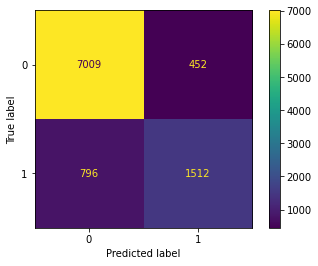

In [46]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train, y_train)

y_pred = lgb_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

**Training CGAN**

In [47]:
cgan = cGAN()

[99/500]	Loss_D: 0.6957	Loss_G: 0.6781
[199/500]	Loss_D: 0.6671	Loss_G: 0.7340
[299/500]	Loss_D: 0.5701	Loss_G: 0.8824
[399/500]	Loss_D: 0.5389	Loss_G: 1.1672
[499/500]	Loss_D: 0.4010	Loss_G: 1.8489


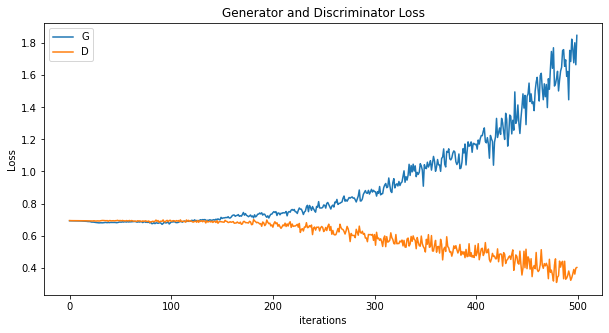

In [48]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=500)

In [49]:
pd.DataFrame(X_train).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,-0.192816,1.454401,-1.154666,-0.332542,1.136512,-0.410397,1.281726,-0.900852,0.392384,0.70422,-0.144804,-0.217127,0.772930,0.289462
1,-0.484566,2.137359,-1.122252,-0.332542,1.136512,-0.410397,1.518107,-0.900852,0.392384,0.70422,-0.144804,-0.217127,-1.648120,0.289462
2,-0.995129,0.088484,0.623182,-0.332542,1.136512,0.916138,-1.318460,-0.276685,0.392384,-1.42001,-0.144804,-0.217127,-0.034087,0.289462
3,-0.557504,1.454401,-0.665257,0.183660,-0.419335,0.916138,-0.845699,0.971649,0.392384,0.70422,-0.144804,-0.217127,0.772930,0.289462
4,0.390683,0.088484,2.072545,0.183660,-0.419335,-1.736932,-1.318460,1.595817,0.392384,-1.42001,-0.144804,-0.217127,-0.034087,0.289462


Generating new instances

In [50]:
# we want to generate 19758 instances with class value 0 since that represents how many 0s are in the label of the real training set
noise = np.random.normal(0, 1, (37155, 32))
sampled_labels = np.zeros(37155).reshape(-1, 1)


gen_samples = cgan.generator.predict([noise, sampled_labels])

gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('income',1).columns)

In [51]:
# we want to generate 6290 instances with class value 1 since that represents how many 1s are in the label of the real training set
noise_2 = np.random.normal(0, 1, (11687, 32))
sampled_labels_2 = np.ones(11687).reshape(-1, 1)


gen_samples_2 = cgan.generator.predict([noise_2, sampled_labels_2])

gen_df_2 = pd.DataFrame(data = gen_samples_2,
                      columns = df.drop('income',1).columns)

Combining generated instances in the dataframe

In [52]:
gen_df_2['income'] = 1
gen_df['income']=0

df_gan = pd.concat([gen_df_2, gen_df], ignore_index=True, sort=False)
df_gan = df_gan.sample(frac=1).reset_index(drop=True)

X_train_2 = df_gan.drop('income', 1)
y_train_2 = df_gan['income'].values

In [53]:
df_gan.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,-0.976869,0.309357,-0.529713,-1.000000,0.994139,0.999940,0.944951,0.458309,1.000000,-0.998993,0.175095,-0.773464,-0.834492,-0.999091,0
1,-0.800116,-0.999931,1.000000,0.999837,0.984732,0.617883,0.938917,-0.694804,-0.530106,1.000000,-0.350398,0.418846,-0.812849,-0.118679,0
2,-1.000000,-0.999625,-0.958189,0.996855,0.999912,1.000000,0.896488,-0.999699,-0.998130,1.000000,-0.928687,-0.847903,0.987985,1.000000,0
3,-0.990156,-0.420158,-0.999992,1.000000,0.999335,0.339528,0.947743,-1.000000,0.999111,1.000000,-0.112679,-0.789565,-0.999985,1.000000,0
4,-1.000000,0.999958,-0.372420,-0.999998,-0.574063,1.000000,1.000000,0.999011,-1.000000,1.000000,-1.000000,-0.280504,-0.979827,-0.984573,0


Classifying testset using generated trainset

              precision    recall  f1-score   support

           0       0.78      0.91      0.84      7461
           1       0.36      0.16      0.22      2308

    accuracy                           0.73      9769
   macro avg       0.57      0.54      0.53      9769
weighted avg       0.68      0.73      0.69      9769



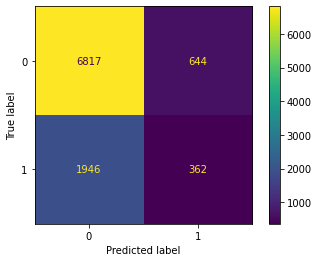

In [54]:
lgb_1 = lgb.LGBMClassifier()
lgb_1.fit(X_train_2, y_train_2)


y_pred = lgb_1.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_1, X_test, y_test)
plt.show()

# **Synthetic Data Vault**

In [55]:
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [56]:
from sdv.tabular import CTGAN

In [57]:
new_df = df.head(5000)
new_df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,4,226802,1,7,4,7,3,2,1,0,0,40,39,0
1,38,4,89814,11,9,2,5,0,4,1,0,0,50,39,0
2,28,2,336951,7,12,2,11,0,4,1,0,0,40,39,1
3,44,4,160323,15,10,2,7,0,2,1,7688,0,40,39,1
4,18,0,103497,15,10,4,0,3,4,0,0,0,30,39,0


Train CTGAN model

In [58]:
model = CTGAN()
model.fit(new_df)

Generate new samples

In [59]:
synthetic_df = model.sample(2000)

In [61]:
from sdv.evaluation import evaluate
evaluate(synthetic_df,new_df)

0.6611072970767475

In [62]:
scaler = StandardScaler()

X = scaler.fit_transform(new_df.drop('income', 1))
y = new_df['income'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Build LGBM on original dataset

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       765
           1       0.72      0.60      0.65       235

    accuracy                           0.85      1000
   macro avg       0.80      0.76      0.78      1000
weighted avg       0.84      0.85      0.85      1000



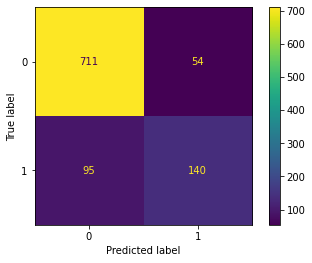

In [63]:
lgb_sdv_1 = lgb.LGBMClassifier()
lgb_sdv_1.fit(X_train, y_train)

y_pred = lgb_sdv_1.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_sdv_1, X_test, y_test)
plt.show()

In [64]:
X_train_2 = synthetic_df.drop('income', 1)
y_train_2 = synthetic_df['income'].values

Build LGBM on synthetic data and predict on original test set

              precision    recall  f1-score   support

           0       0.77      1.00      0.87       765
           1       0.00      0.00      0.00       235

    accuracy                           0.77      1000
   macro avg       0.38      0.50      0.43      1000
weighted avg       0.59      0.77      0.66      1000



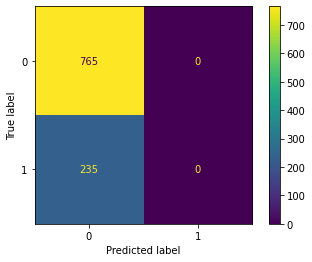

In [65]:
lgb_sdv_2 = lgb.LGBMClassifier()
lgb_sdv_2.fit(X_train_2, y_train_2)


y_pred = lgb_sdv_2.predict(X_test)

print(classification_report(y_test, y_pred))
plot_confusion_matrix(lgb_sdv_2, X_test, y_test)
plt.show()